# Using Convolutional Neural Networks

Welcome to the first week of the first deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

## Introduction to this week's task: 'Dogs vs Cats'

We're going to try to create a model to enter the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): *"**State of the art**: The current literature suggests machine classifiers can score above 80% accuracy on this task"*. So if we can beat 80%, then we will be at the cutting edge as of 2013!

## Basic setup

There isn't too much to do to get started - just a few simple configuration steps.

This shows plots in the web page itself - we always wants to use this when using jupyter notebook:

In [1]:
%matplotlib inline

Define path to data: (It's a good idea to put it in a subdirectory of your notebooks folder, and then exclude that directory from git control by adding it to .gitignore.)

In [2]:
path = "../data/dogscatskaggle/"
# path = "../data/dogscatskaggle/sample/"

A few basic libraries that we'll need for the initial exercises:

In [3]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

We have created a file most imaginatively called 'utils.py' to store any little convenience functions we'll want to use. We will discuss these as we use them.

In [4]:
import utils; reload(utils)
from utils import plots

/home/ubuntu/anaconda2/envs/py22/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7003 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
Using Theano backend.


# Use a pretrained VGG model with our **Vgg16** class

Our first step is simply to use a model that has been fully created for us, which can recognise a wide variety (1,000 categories) of images. We will use 'VGG', which won the 2014 Imagenet competition, and is a very simple model to create and understand. The VGG Imagenet team created both a larger, slower, slightly more accurate model (*VGG  19*) and a smaller, faster model (*VGG 16*). We will be using VGG 16 since the much slower performance of VGG19 is generally not worth the very minor improvement in accuracy.

We have created a python class, *Vgg16*, which makes using the VGG 16 model very straightforward. 

## The punchline: state of the art custom model in 7 lines of code

Here's everything you need to do to get >97% accuracy on the Dogs vs Cats dataset - we won't analyze how it works behind the scenes yet, since at this stage we're just going to focus on the minimum necessary to actually do useful work.

In [12]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

In [9]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [7]:
vgg = Vgg16()
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 19999 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/1
19999/19999 [==============================] - 554s - loss: 0.1242 - acc: 0.9664 - val_loss: 0.0560 - val_acc: 0.9832


In [32]:
vgg.model.save_weights(path+'ft1.h5')

The code above will work for any image recognition task, with any number of categories! All you have to do is to put your images into one folder per category, and run the code above.

Let's take a look at how this works, step by step...

In [8]:
batches, predictions = vgg.test(path+'test')


Found 12500 images belonging to 1 classes.


In [25]:
is_dog = np.clip(predictions[:,1], 0.05, 0.95)
print(is_dog)
filenames = batches.filenames
# print(filenames)

[ 0.95  0.95  0.95 ...,  0.05  0.05  0.05]


In [26]:
ids = [int(f[7:f.find('.')]) for f in filenames]
# print(ids)

In [27]:
subm = np.stack([ids, is_dog], axis=1)
print(subm)

[[  7.1900e+03   9.5000e-01]
 [  8.8620e+03   9.5000e-01]
 [  7.1790e+03   9.5000e-01]
 ..., 
 [  4.0600e+03   5.0000e-02]
 [  7.5390e+03   5.0000e-02]
 [  2.6490e+03   5.0000e-02]]


In [28]:
np.savetxt("submission3.csv", subm, fmt='%d,%.5f', header='id,label', comments='')

In [19]:
from IPython.display import FileLink
FileLink('submission2.csv')

/home/ubuntu/data_drive/oren_fast.ai/courses/deeplearning1/nbs/submission2.csv

# visualization

In [10]:
vgg = Vgg16()

In [13]:
vgg.model.load_weights(path+'ft1.h5')
val_batches, probs = vgg.test(path+'valid', batch_size = batch_size)

Found 5000 images belonging to 2 classes.


In [14]:
labels = val_batches.classes
filenames = val_batches.filenames
print(probs)

[[  1.0000e+00   5.8038e-10]
 [  9.9999e-01   1.4042e-05]
 [  1.0000e+00   2.9822e-11]
 ..., 
 [  1.3367e-10   1.0000e+00]
 [  4.2473e-06   1.0000e+00]
 [  3.8262e-02   9.6174e-01]]


In [15]:
probs = probs[:,0]
preds = np.round(1-probs)
print(preds)

[ 0.  0.  0. ...,  1.  1.  1.]


In [16]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/'+ filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

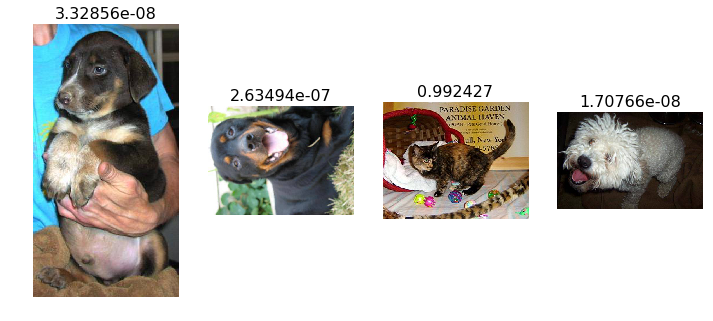

In [17]:
import numpy as np
from numpy.random import random, permutation, randn, normal, uniform, choice

#1. A few correct labels at random
correct = np.where(preds==labels)[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

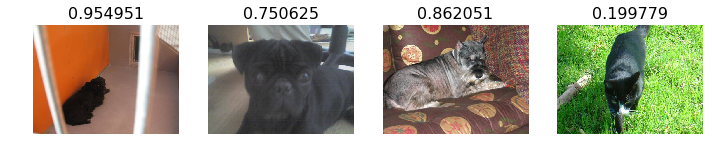

In [18]:
#2. A few incorrect labels at random
correct = np.where(preds!=labels)[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

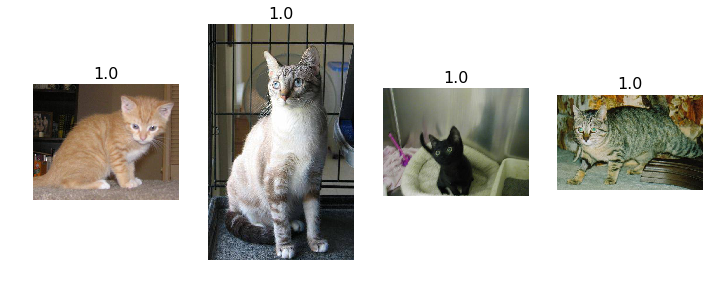

In [19]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((preds==0) & (preds==labels))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

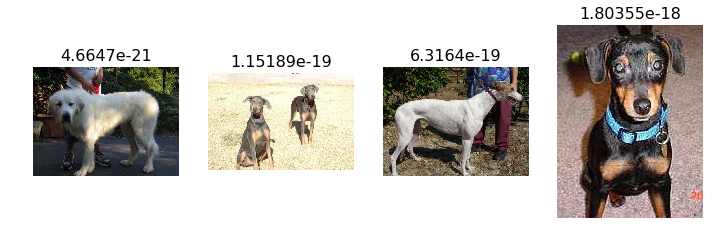

In [20]:
#3a. The images we most confident were dogs, and are actually dog s
correct_dogs = np.where((preds==1) & (preds==labels))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], probs[correct_dogs][most_correct_dogs])

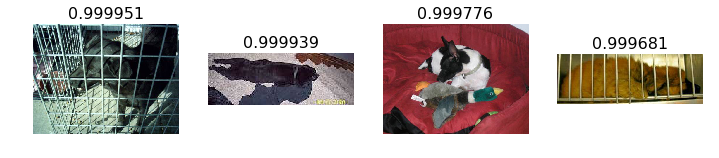

In [21]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((preds==0) & (preds!=labels))[0]
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])

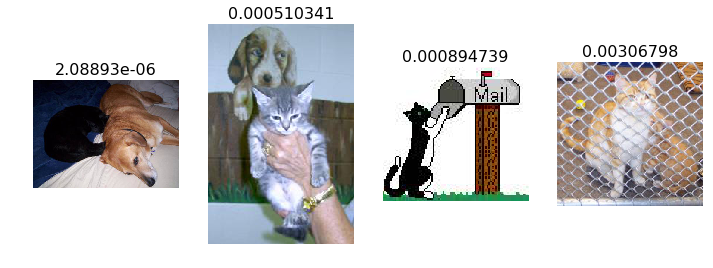

In [22]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((preds==1) & (preds!=labels))[0]
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], probs[incorrect_dogs][most_incorrect_dogs])

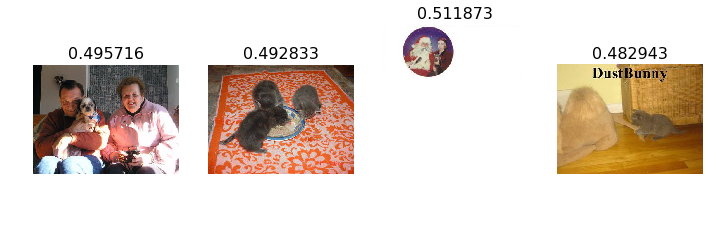

In [23]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])

In [26]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.fit(batches, val_batches, nb_epoch=1)

vgg.model.save_weights(path+'ft2.h5')


Found 19999 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/1
19999/19999 [==============================] - 547s - loss: 0.0918 - acc: 0.9768 - val_loss: 0.0764 - val_acc: 0.9812
